# Replicate analysis w Nelson table

In [370]:
import os,sys
import pandas as pd
import numpy as np

import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from sc_target_evidence_utils import association_utils, sc_evidence_utils


In [358]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [359]:
%load_ext rpy2.ipython

In [360]:
%%R
library(tidyverse)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [362]:
figdir = '/home/jovyan/mount/gdrive/sc_targetID/plots/association_results_nelson/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [365]:
def _palette_df_from_dict(palette_dict):
    palette_df = pd.DataFrame(palette_dict.values(), index=palette_dict.keys())
    palette_df.columns = ['color']
    return(palette_df)
    
## Gene classes 
GENE_CLASS_ORDER = ['nuclear_receptors', 'catalytic_receptors', 'rhodop_gpcr', 'transporters', 'kinases', 'enzymes', 'ion_channels', 'other']
gene_class_palette = {
    x:sns.color_palette('Set1').as_hex()[i] if x != 'other' else sns.color_palette('Set1').as_hex()[-1] for i,x in enumerate(GENE_CLASS_ORDER)
}
gene_class_palette_df = _palette_df_from_dict(gene_class_palette)

In [366]:
%%R -i gene_class_palette_df -i figdir
gene_class_palette <- setNames(gene_class_palette_df$color, rownames(gene_class_palette_df))

# utils
ggsave_figdir <- function(output_name, width, height){
    ggsave(paste0(figdir, output_name, '.png'), width = width, height = height) 
    ggsave(paste0(figdir, output_name, '.pdf'), width = width, height = height)
}


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [367]:
## Get disease info from curated metadata
data_dir = "/nfs/team205/ed6/bin/sc_target_evidence/data/"
cxg_metadata = pd.read_csv(data_dir + 'cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)

disease_info_df = cxg_metadata[['disease_relevant_tissue', 'disease_ontology_id', 'disease']].drop_duplicates()
disease_name_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease']))
disease_tissue_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease_relevant_tissue']))

In [371]:
tissue_colors = sc.pl.palettes.default_20
tissue_palette_dict = dict(zip(disease_info_df['disease_relevant_tissue'].unique(), tissue_colors))
tissue_palette_df = _palette_df_from_dict(tissue_palette_dict)

In [372]:
%%R -i tissue_palette_df -i figdir
tissue_palette <- setNames(tissue_palette_df$color, rownames(tissue_palette_df))



/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [373]:
## Get table of all genes
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
genes = ensdb.genes()

In [374]:
%%R

### Plotting utils
evidence_labels <- c(
    "all_sc_evidence" = "cell type & disease cell specific", 
    "bulk_disease_evidence" = "DE in disease (tissue)", 
    "disease_ct_evidence" = "DE in disease (cell type)", 
    "disease_evidence" = "Disease cell specific", 
    "ct_marker_evidence" = "Cell type specific", 
    "has_genetic_support" = "Genetic association"
    )

universe_labels <- c(
    'protein_coding_targets'= 'protein-coding targets',
    'sm_tractable_targets' = 'SM tractable targets',
    'ab_tractable_targets' = "Ab tractable targets",
    'known_drug_targets' = 'known drug targets\n(reached phase I)',
    'nuclear_receptors' = 'nuclear receptors', 
    'catalytic_receptors' = 'catalytic receptors', 
    'rhodop_gpcr' = 'rhodopsin-like\nGPCRs', 
    'transporters' = 'transporters', 
    'kinases' = 'kinases', 
    'enzymes' = 'enzymes', 
    'ion_channels' = 'ion channels'
    )


# Plot odds-ratio (no faceting)
plot_OR <- function(
    results_all_df, 
    pval_alpha=0.05, 
    base_font_size=20,
    text_position='right',
    y_value = 'clinical_status',
    evidence_levels = c('ct_marker_evidence', 'disease_evidence', 'disease_ct_evidence', 'bulk_disease_evidence', 'has_genetic_support', 'all_sc_evidence', 'is_hvg_normal', 'is_hvg_disease'),
    clinical_status_levels = c(rev(c('druggable', 'safe', 'effective', 'approved'))),
    hide_zeros = TRUE
){
    pl_df <- results_all_df %>%
        mutate(clinical_status = factor(str_remove(clinical_status, 'is_'), levels=clinical_status_levels)) %>%
        mutate(evidence = factor(evidence, levels=evidence_levels)) %>%
        mutate(is_signif = pval < pval_alpha) %>%
        rename(setNames(y_value,'y_val')) 
    
    pl <- ggplot(pl_df, aes(y=y_val, x=odds_ratio, color=is_signif)) 
    
    if (isTRUE(hide_zeros)){
        pl <- pl +
            geom_point(
                data = . %>% filter(n_supported_approved > 0),
                size=3
            ) +
            geom_pointrange(data = . %>% filter(n_supported_approved > 0),
                            aes(xmin=ci_low, xmax=ci_high))
    } else {
        pl <- pl +
            geom_point(size=3) +
            geom_pointrange(aes(xmin=ci_low, xmax=ci_high))}
        
    pl <- pl + geom_text(aes(label = paste0(n_supported_approved,' / ', n_success)), 
                      x = ifelse(text_position == 'right', Inf, -Inf) , 
                      hjust= ifelse(text_position == 'right', 1.1, -1) , 
                      size=5,
                      color='black',) +
        geom_vline(xintercept=1, linetype=2) +
        scale_x_log10(labels = scales::label_number()) +
        xlab('Odds Ratio') +
        ylab(y_value) +
        theme_classic(base_size=base_font_size) +
        scale_color_manual(values=c('TRUE' = 'red', 'FALSE'='grey50'), 
                           name=paste0("Significant enrichment\n(Fisher's test p-value < ", round(pval_alpha, digits=2), ')')) +
        theme(strip.text.y=element_text(angle=0), strip.background = element_rect(color=NA, fill = "grey"))    
    pl
}

In [375]:
## Get disease info from curated metadata
data_dir = "/nfs/team205/ed6/bin/sc_target_evidence/data/"
cxg_metadata = pd.read_csv(data_dir + 'cellxgene_hsapiens_donor_metadata.disease_relevant_annotation.csv', index_col=0)

disease_info_df = cxg_metadata[['disease_relevant_tissue', 'disease_ontology_id', 'disease']].drop_duplicates()
disease_name_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease']))
disease_tissue_mapper = dict(zip(disease_info_df['disease_ontology_id'], disease_info_df['disease_relevant_tissue']))

## Clean Nelson table

In [104]:
cr_df = pd.read_csv('../data/nelson_s01_cross_references.csv', encoding='cp1252', index_col=0)

In [53]:
## Get table of all genes
import genomic_features as gf
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")

In [105]:
genes = ensdb.genes(cols=["gene_id", "gene_name"])

In [115]:
# Read old tables
OT_targets_df =  pd.read_csv('../data/TargetDiseasePairs_OpenTargets_cellXgeneID_12072023.clean.csv', index_col=0)
targets_evidence_all = pd.read_csv( '../data/disease_target_evidence.all.csv', index_col=0)

In [503]:
keep_columns = ['ti_uid', 'indication_mesh_term','target', 'combined_max_phase', 'succ_p_1', 'succ_1_2',
       'succ_2_3', 'succ_3_a', 'areas', 'target_status', 'MONDO']
rename_columns = {
    'target':'gene_name'
}

nelson_targets_df = cr_df[keep_columns].copy()
nelson_targets_df = nelson_targets_df.rename(rename_columns, axis=1)

In [504]:
## Add gene ids
genes = genes.groupby('gene_name').first()

shared_names = np.intersect1d(genes.index, nelson_targets_df.gene_name)
missing_names = np.setdiff1d(nelson_targets_df.gene_name, shared_names)

rename_missing_names = {
    'TMEM173':'STING1',
    'ACPP':'ACP3',
    'COL4A3BP':'CERT1',
    'G6PC':'G6PC1',
    'H3F3A':'H3-3A',
    'HARS':'HARS1',
    'HIST1H1C':'H1-2',
    'HIST1H1D':'H1-3',
    'HIST1H1E':'H1-4',
    'KARS':'KARS1',
    'PHB':'PHB1',
    'QARS':'QARS1',
    'RARRES3':'PLAAT4', 
    }

nelson_targets_df['gene_name'] = [rename_missing_names[x] if x in rename_missing_names.keys() else x for x in nelson_targets_df.gene_name]

nelson_targets_df = pd.merge(nelson_targets_df, genes, on='gene_name', how='left')

In [505]:
nelson_targets_df

,ti_uid,indication_mesh_term,gene_name,combined_max_phase,succ_p_1,succ_1_2,succ_2_3,succ_3_a,areas,target_status,...,gene_id,gene_biotype,gene_seq_start,gene_seq_end,seq_name,seq_strand,seq_coord_system,description,gene_id_version,canonical_transcript
0,MAOB-D000015,"Abnormalities, Multiple",MAOB,Preclinical,NaN,NaN,NaN,NaN,congenital,unsupported target,...,ENSG00000069535,protein_coding,43766610.0,43882450.0,X,-1.0,chromosome,monoamine oxidase B [Source:HGNC Symbol;Acc:HG...,ENSG00000069535.14,ENST00000378069
1,BRAF-D000015,"Abnormalities, Multiple",BRAF,Preclinical,NaN,NaN,NaN,NaN,congenital,unsupported target,...,ENSG00000157764,protein_coding,140719327.0,140924929.0,7,-1.0,chromosome,"B-Raf proto-oncogene, serine/threonine kinase ...",ENSG00000157764.14,ENST00000646891
2,KDM1A-D000015,"Abnormalities, Multiple",KDM1A,Preclinical,NaN,NaN,NaN,NaN,congenital,unsupported target,...,ENSG00000004487,protein_coding,23019443.0,23083689.0,1,1.0,chromosome,lysine demethylase 1A [Source:HGNC Symbol;Acc:...,ENSG00000004487.18,ENST00000400181
3,TRPV1-D000070607,Morton Neuroma,TRPV1,Phase III,True,True,True,False,"musculoskeletal, neurology, signs/symptoms",unsupported target,...,ENSG00000196689,protein_coding,3565444.0,3609411.0,17,-1.0,chromosome,transient receptor potential cation channel su...,ENSG00000196689.13,ENST00000572705
4,MTNR1B-D000071057,Tardive Dyskinesia,MTNR1B,Preclinical,False,NaN,NaN,NaN,"neurology, signs/symptoms",unsupported target,...,ENSG00000134640,protein_coding,92969651.0,92985066.0,11,1.0,chromosome,melatonin receptor 1B [Source:HGNC Symbol;Acc:...,ENSG00000134640.3,ENST00000257068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25942,SLC6A4-D065886,Neurodevelopmental Disorders,SLC6A4,Phase III,True,True,True,NaN,psychiatry,unsupported target,...,ENSG00000108576,protein_coding,30194319.0,30236002.0,17,-1.0,chromosome,solute carrier family 6 member 4 [Source:HGNC ...,ENSG00000108576.10,ENST00000650711
25943,HTR1A-D065886,Neurodevelopmental Disorders,HTR1A,Preclinical,False,NaN,NaN,NaN,psychiatry,unsupported target,...,ENSG00000178394,protein_coding,63957874.0,63962507.0,5,-1.0,chromosome,5-hydroxytryptamine receptor 1A [Source:HGNC S...,ENSG00000178394.5,ENST00000323865
25944,CNR2-D065886,Neurodevelopmental Disorders,CNR2,Preclinical,False,NaN,NaN,NaN,psychiatry,unsupported target,...,ENSG00000188822,protein_coding,23870515.0,23913362.0,1,-1.0,chromosome,cannabinoid receptor 2 [Source:HGNC Symbol;Acc...,ENSG00000188822.8,ENST00000374472
25945,CYP46A1-D065886,Neurodevelopmental Disorders,CYP46A1,Phase II,True,True,False,NaN,psychiatry,unsupported target,...,ENSG00000036530,protein_coding,99684298.0,99727301.0,14,1.0,chromosome,cytochrome P450 family 46 subfamily A member 1...,ENSG00000036530.9,ENST00000261835


In [506]:
dummies = nelson_targets_df['areas'].str.get_dummies(sep=', ')

# Concatenate with original DataFrame
nelson_targets_df = pd.concat([nelson_targets_df, dummies], axis=1)


In [507]:
## Save max phase as ordered categorical
nelson_targets_df['combined_max_phase'] = nelson_targets_df['combined_max_phase'].astype('category').cat.reorder_categories(['Preclinical','Phase I', 'Phase II', 'Phase III', 'Launched'])

In [508]:
all_areas = dummies.columns.tolist()

Count t-i pairs per area

In [691]:
ti_pairs_by_area = pd.DataFrame(columns=['area', 'N_disease', 'N_TD_pairs'])
ti_pairs_area_df = nelson_targets_df[['indication_mesh_term', 'ti_uid'] + all_areas]
for a in all_areas:
    ndiseases = ti_pairs_area_df[ti_pairs_area_df[a] == 1]['indication_mesh_term'].nunique()
    ndiseases_t = ti_pairs_area_df[ti_pairs_area_df[a] == 1]['ti_uid'].nunique()
    df = pd.DataFrame(np.array([a, ndiseases, ndiseases_t]), index= ['area', 'N_disease', 'N_TD_pairs']).T
    ti_pairs_by_area = pd.concat([ti_pairs_by_area, df])

In [692]:
ti_pairs_by_area

,area,N_disease,N_TD_pairs
0,cardiovascular,71,1798
0,congenital,170,1095
0,dermatology,76,1865
0,digestive,50,1424
0,endocrine,34,958
0,hematology,59,726
0,immune,56,2132
0,infection,39,902
0,metabolic,114,1501
0,musculoskeletal,48,1011


In [510]:
test_areas = {
    'lung':['respiratory'], 
    'stomach':['digestive'], 
    'nose':['respiratory'], 
    'small intestine':['digestive'], 
    'kidney':[], 
    'heart':['cardiovascular'],
    'lymph node':['hematology', 'immune'],
    'blood':['hematology', 'immune', 'infection'],
    'prostate gland':[],
    'esophagus':['digestive'],
    'pancreas':[],
    'breast':[],
    'colon':['digestive']
}

## Get single-cell support - cell type specificity only 

In [158]:
def _parse_DE(
    disease_ontology_id, 
    OT_targets_df,
    signif_thresh = 0.01,
    DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0},
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    '''Parse DE outputs for each disease and merge with OT clinical status and genetic evidence.
    
    Params
    ------
    disease_ontology_id
        Disease MONDO ID
    OT_targets_df
        Dataframe of OpenTargets target-disease pairs
    signif_thresh
        Threshold for DE adjusted p-value
    DE2evidence_celltype_params
        parameters passed to `DE2evidence_celltype_params`
    DE2evidence_disease_params
        parameters passed to `DE2evidence_disease_params`
    data_dir 
        path to directory storing DE results
        
    Returns
    -------
    targets_disease_df
        DataFrame of target-disease pairs with clinical status and omics evidence.
    '''
    ct_res = pd.read_csv(f'{data_dir}/DE_celltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
 
    evidence_dict = sc_evidence_utils.DE2evidence_celltype(
        ct_res, signif_thresh=signif_thresh, **DE2evidence_celltype_params)
    evidence_dict['is_hvg_normal'] = ct_res.gene_id.unique()
    # Make target-disease table for sc evidence
    targets_disease_df = pd.DataFrame()
    targets_disease_df['gene_id'] = np.unique(np.hstack([x for x in evidence_dict.values()])) # Get all targets with sc evidence
    targets_disease_df['disease_ontology_id'] = disease_ontology_id

    for ev,targets in evidence_dict.items():
        targets_disease_df[ev] = targets_disease_df.gene_id.isin(targets).astype(int)
    return(targets_disease_df)

In [153]:
## Get all disease IDs
data_dir = '../data'
all_pbulk_files = [x for x in os.listdir(data_dir) if x.endswith('pbulk_all_genes.h5ad')]
all_disease_ids = [x.replace('.pbulk_all_genes.h5ad', '').replace('cellxgene_targets_', '') for x in all_pbulk_files]
all_disease_ids = [x for x in all_disease_ids if x.startswith("MONDO")]

In [159]:
## Save evidence results for each disease
targets_evidence_all = pd.DataFrame()
for disease_ontology_id in all_disease_ids:
    try:
        targets_disease_df = _parse_DE(
            disease_ontology_id, 
            OT_targets_df,
            signif_thresh = 0.01,
            DE2evidence_celltype_params = {"lfc_thresh":5.0, 'ct_fraction_thresh':1.0}
        )
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue
    targets_disease_df['disease'] = disease_name_mapper[disease_ontology_id.replace('_', ":")]
    targets_disease_df['disease_relevant_tissue'] = disease_tissue_mapper[disease_ontology_id.replace('_', ":")]
    targets_evidence_all = pd.concat([targets_evidence_all, targets_disease_df], axis=0)

In [285]:
## Group evidence by tissue
ct_targets_df = targets_evidence_all[['gene_id', 'disease_relevant_tissue', 'is_hvg_normal', 'ct_marker_evidence']].drop_duplicates().groupby(['gene_id', 'disease_relevant_tissue']).max().reset_index()

In [287]:
ct_targets_df = pd.merge(ct_targets_df, genes.reset_index(), on='gene_id', how='left')

### Test by area

In [288]:
max_phase_dict = {i:x for i,x in enumerate(nelson_targets_df['combined_max_phase'].cat.categories)}

In [558]:
test_areas = {
    'respiratory':['lung', 'nose'],
    'digestive':['colon', 'stomach', 'esophagus', 'small intestine'],
    'cardiovascular':['heart'],
    'hematology':['blood'],
    'immune':['blood', 'lymph node'],
    'infection':['blood', 'lymph node']
}

In [587]:
success_cols = ['succ_p_1', 'succ_1_2', 'succ_2_3', 'succ_3_a']

def get_area_df(area_oi, filter_congenital=False):
    area_ev_df = ct_targets_df[ct_targets_df.disease_relevant_tissue.isin(test_areas[area_oi])].drop('disease_relevant_tissue', axis=1)
    area_ev_df = area_ev_df.groupby(['gene_id']).max().reset_index() ## Evidence if ct marker in any tissue
    area_target_df = nelson_targets_df[nelson_targets_df[area_oi] == 1].copy()
    if filter_congenital:
        area_target_df = area_target_df[area_target_df['congenital'] == 0].copy()
    ## Get highest phase reached for any indication in area
    area_target_df['combined_max_phase'] = area_target_df['combined_max_phase'].cat.codes
    area_target_df = area_target_df.groupby(['gene_id', 'gene_name'])[['succ_p_1', 'succ_1_2', 'succ_2_3', 'succ_3_a', 'combined_max_phase']].max().reset_index()
    area_target_df['combined_max_phase'] = [max_phase_dict[x] for x in area_target_df['combined_max_phase']]
    area_target_df = area_target_df.fillna(False) # if target hasn't reached phase, mark as False in success cols
    ## Get genetic evidence for any indication in area
    area_genetic_df = nelson_targets_df[nelson_targets_df[area_oi] == 1][['gene_id', 'gene_name', 'target_status']].copy()
    area_genetic_df['has_genetic_evidence'] = np.where(area_genetic_df.target_status == 'unsupported target', 0, 1)
    area_genetic_df = area_genetic_df.groupby(['gene_id', 'gene_name']).max().reset_index()
    area_test_df = pd.merge(area_ev_df, area_target_df, how='outer')
    area_test_df = pd.merge(area_test_df, area_genetic_df, how='outer')
    area_test_df['combined_max_phase'] = area_test_df['combined_max_phase'].fillna('None')
    area_test_df[success_cols] = area_test_df[success_cols].fillna(False)
    area_test_df[success_cols] = area_test_df[success_cols].astype(int)
    area_test_df = area_test_df.fillna(0)
    return(area_test_df)

In [328]:
# max_phase_dummies = pd.get_dummies(area_target_df['combined_max_phase'])
# max_phase_dummies.columns = [f"max_phase_{max_phase_dict[x].replace(' ', '_')}" for x in max_phase_dummies.columns] 
# area_target_df = pd.concat([area_target_df,max_phase_dummies], axis=1)

In [603]:
all_area_count_df = pd.DataFrame()
for area in test_areas.keys():
    area_test_df = get_area_df(area)
    area_count_df = pd.crosstab(area_test_df['combined_max_phase'], area_test_df['is_hvg_normal'])
    area_count_df.columns = ['not_HVG', 'is_HVG']
    area_count_df['area'] = area
    all_area_count_df = pd.concat([all_area_count_df, area_count_df])

all_area_count_df = all_area_count_df.reset_index()

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


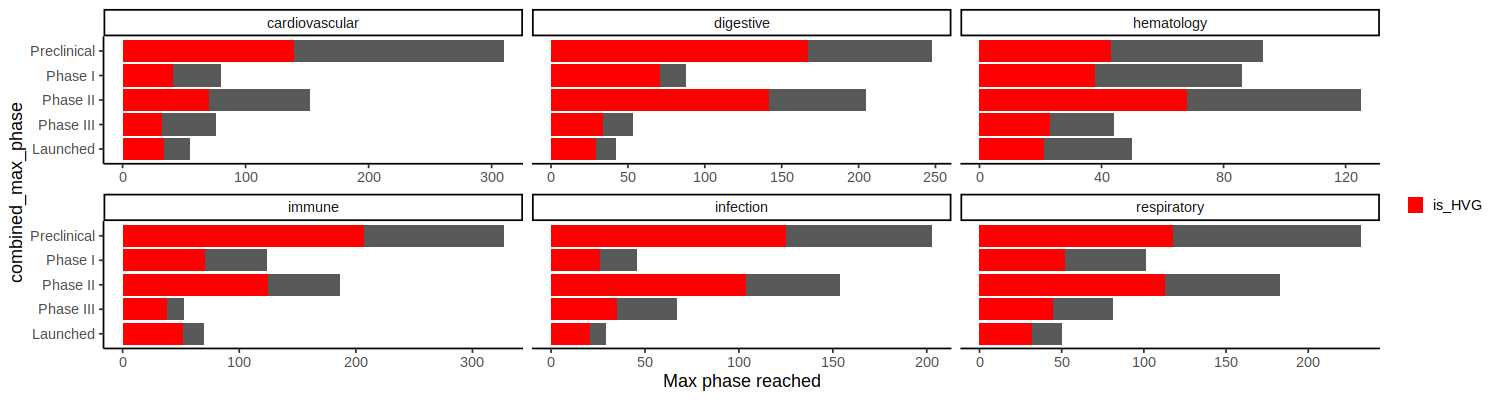

In [628]:
%%R -i all_area_count_df -w 1500 -h 400
all_area_count_df %>%
mutate(combined_max_phase = factor(
    combined_max_phase, 
    levels = rev(c( 'Preclinical', 'Phase I', 'Phase II', 'Phase III','Launched')))) %>%
mutate(total = not_HVG+is_HVG) %>%
filter(combined_max_phase != 'None') %>%
ggplot(aes(combined_max_phase, total)) +
geom_col() +
geom_col(aes(y=is_HVG, fill='is_HVG')) +
theme_classic(base_size=18) +
scale_fill_manual(values=c('red'), name='') +
ylab('Max phase reached') +
facet_wrap(area~., scales='free_x') + coord_flip()

In [637]:
results_all_df = pd.DataFrame()
for area in test_areas.keys():
    area_test_df = get_area_df(area)
    for ph in success_cols:
        for ev in ['ct_marker_evidence', 'has_genetic_evidence']:
            or_df = association_utils.get_OR(
                area_test_df[area_test_df.is_hvg_normal==1],  # universe HVGs
                evidence_col = ev, clinical_status_col=ph)
            or_df['universe'] = 'HVGs'
            or_df['area'] = area
            results_all_df = pd.concat([results_all_df, or_df], axis=0)
            or_df = association_utils.get_OR(
                area_test_df[area_test_df['combined_max_phase'] != 'None'],  # universe preclinical
                evidence_col = ev, clinical_status_col=ph)
            or_df['universe'] = 'preclinical'
            or_df['area'] = area
            results_all_df = pd.concat([results_all_df, or_df], axis=0)
            or_df = association_utils.get_OR(
                area_test_df[(area_test_df['combined_max_phase'] != 'None') & (area_test_df.is_hvg_normal==1)],  # universe preclinical
                evidence_col = ev, clinical_status_col=ph)
            or_df['universe'] = 'preclinical_HVGs'
            or_df['area'] = area
            results_all_df = pd.concat([results_all_df, or_df], axis=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


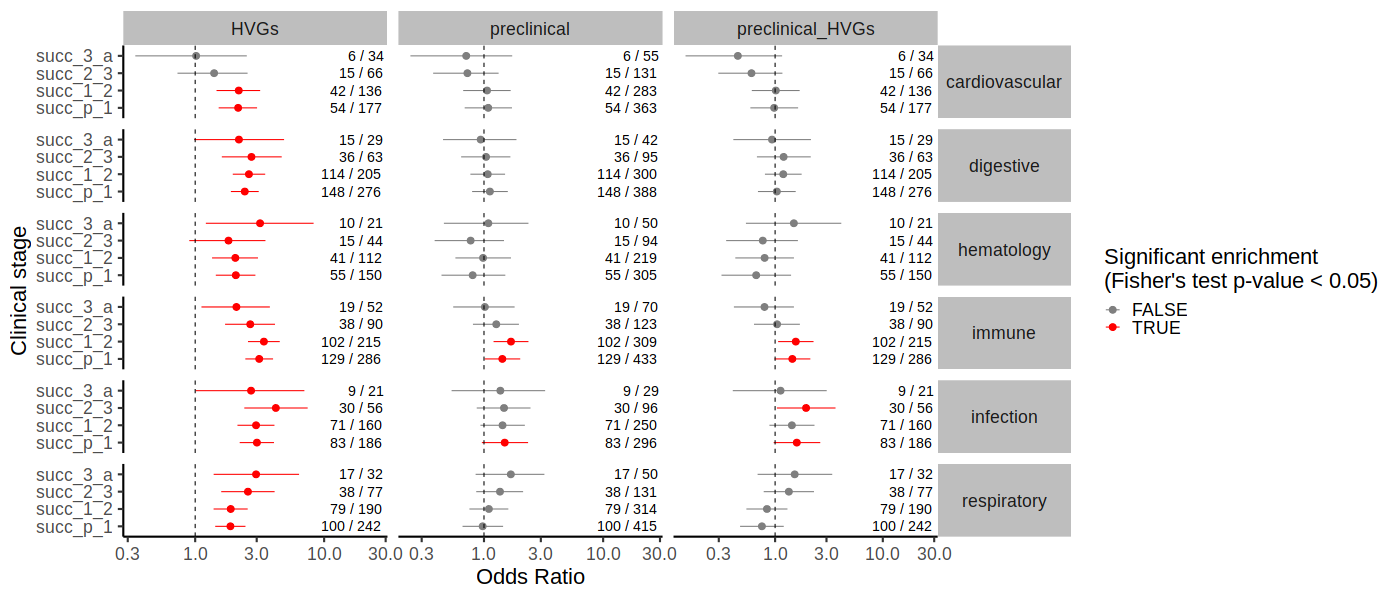

In [639]:
%%R -i results_all_df -w 1400 -h 600 -i figdir
pl_df <- results_all_df %>% filter(evidence == 'ct_marker_evidence')
plot_OR(pl_df, y_value='clinical_status',
        text_position='right', 
        evidence_levels=c('ct_marker_evidence'),
        clinical_status_levels = c('succ_p_1', 'succ_1_2', 'succ_2_3', 'succ_3_a'),
               base_font_size=22
       ) +
    facet_grid(area~universe, scales='free_x'
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
               
              ) +
    ylab("Clinical stage") +
    expand_limits(x=25) 


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


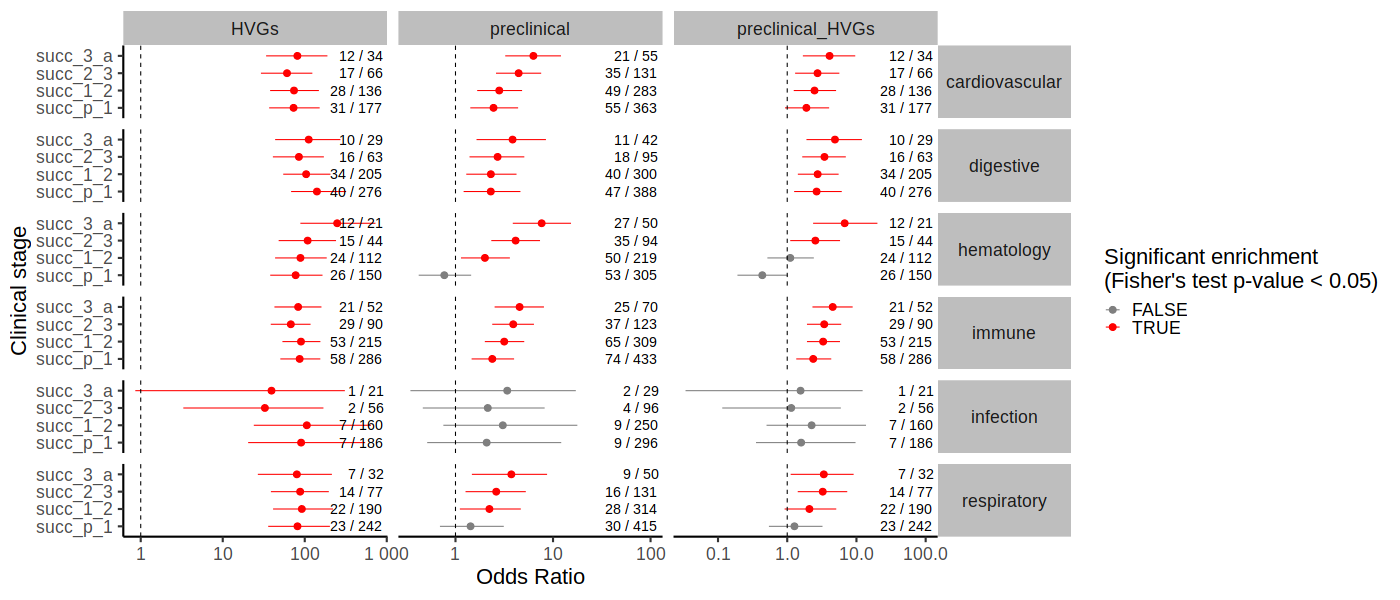

In [640]:
%%R -i results_all_df -w 1400 -h 600 -i figdir
pl_df <- results_all_df %>% filter(evidence == 'has_genetic_evidence' )
plot_OR(pl_df, y_value='clinical_status',
        text_position='right', 
        evidence_levels=c('ct_marker_evidence'),
        clinical_status_levels = c('succ_p_1', 'succ_1_2', 'succ_2_3', 'succ_3_a'),
               base_font_size=22
       ) +
    facet_grid(area~universe, scales='free_x'
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
               
              ) +
    ylab("Clinical stage") +
    expand_limits(x=100) 


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


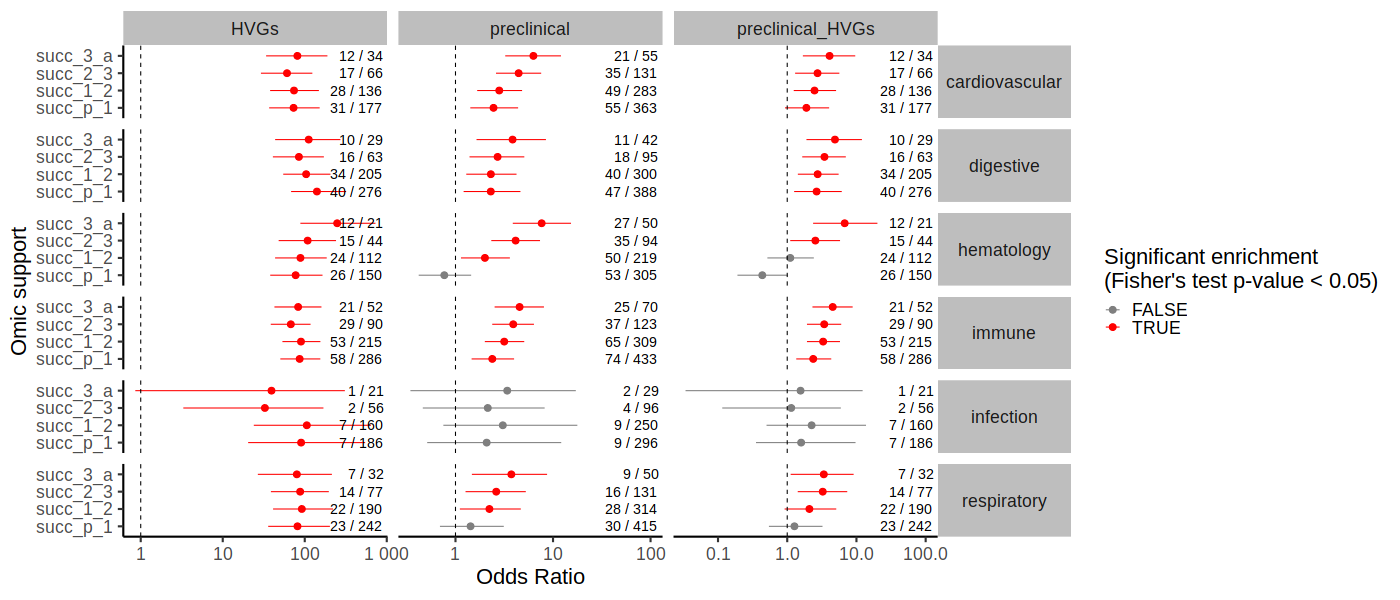

In [577]:
%%R -i results_all_df -w 1400 -h 600 -i figdir
pl_df <- results_all_df %>% filter(evidence == 'has_genetic_evidence' )
plot_OR(pl_df, y_value='clinical_status',
        text_position='right', 
        evidence_levels=c('ct_marker_evidence'),
        clinical_status_levels = c('succ_p_1', 'succ_1_2', 'succ_2_3', 'succ_3_a'),
               base_font_size=22
       ) +
    facet_grid(area~universe, scales='free_x'
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
               
              ) +
    ylab("Omic support") +
    expand_limits(x=100) 


Caveats: 
- genetic evidence here across diseases and associated mesh terms and not tissue-specific 

In [641]:
def get_area_df_by_stage(area_oi, success_col):
    area_ev_df = ct_targets_df[ct_targets_df.disease_relevant_tissue.isin(test_areas[area_oi])].drop('disease_relevant_tissue', axis=1)
    area_ev_df = area_ev_df.groupby(['gene_id']).max().reset_index() ## Evidence if ct marker in any tissue
    area_target_df = nelson_targets_df[nelson_targets_df[area_oi] == 1].copy()
    ## Get highest phase reached for any indication in area
    area_target_df = area_target_df.groupby(['gene_id', 'gene_name'])[success_col].max().reset_index()
    ## Get genetic evidence for any indication in area
    area_genetic_df = nelson_targets_df[nelson_targets_df[area_oi] == 1][['gene_id', 'gene_name', 'target_status']].copy()
    area_genetic_df['has_genetic_evidence'] = np.where(area_genetic_df.target_status == 'unsupported target', 0, 1)
    area_genetic_df = area_genetic_df.groupby(['gene_id', 'gene_name']).max().reset_index()
    area_test_df = pd.merge(area_ev_df, area_target_df, how='outer')
    area_test_df = pd.merge(area_test_df, area_genetic_df, how='outer')
    area_test_df = area_test_df.dropna(subset=[success_col])
    area_test_df[success_col] = area_test_df[success_col].fillna(False)
    area_test_df[success_col] = area_test_df[success_col].astype(int)
    return(area_test_df)

In [642]:
results_filt_all_df = pd.DataFrame()
for area in test_areas.keys():
    for ph in success_cols:
        area_test_df = get_area_df_by_stage(area, ph)
        for ev in ['ct_marker_evidence', 'has_genetic_evidence']:
            or_df = association_utils.get_OR(
                area_test_df[area_test_df.is_hvg_normal==1],  # universe HVGs
                evidence_col = ev, clinical_status_col=ph)
            or_df['universe'] = 'HVGs'
            or_df['area'] = area
            results_filt_all_df = pd.concat([results_filt_all_df, or_df], axis=0)
            or_df = association_utils.get_OR(
                area_test_df,  # universe all preclinical
                evidence_col = ev, clinical_status_col=ph)
            or_df['universe'] = 'all'
            or_df['area'] = area
            results_filt_all_df = pd.concat([results_filt_all_df, or_df], axis=0)
#             or_df = association_utils.get_OR(
#                 area_test_df[area_test_df['combined_max_phase'] != 'None'],  # universe preclinical
#                 evidence_col = ev, clinical_status_col=ph)
#             or_df['universe'] = 'preclinical'
#             or_df['area'] = area
#             results_all_df = pd.concat([results_all_df, or_df], axis=0)
#             or_df = association_utils.get_OR(
#                 area_test_df[(area_test_df['combined_max_phase'] != 'None') & (area_test_df.is_hvg_normal==1)],  # universe preclinical
#                 evidence_col = ev, clinical_status_col=ph)
#             or_df['universe'] = 'preclinical_HVGs'
#             or_df['area'] = area
#             results_all_df = pd.concat([results_all_df, or_df], axis=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


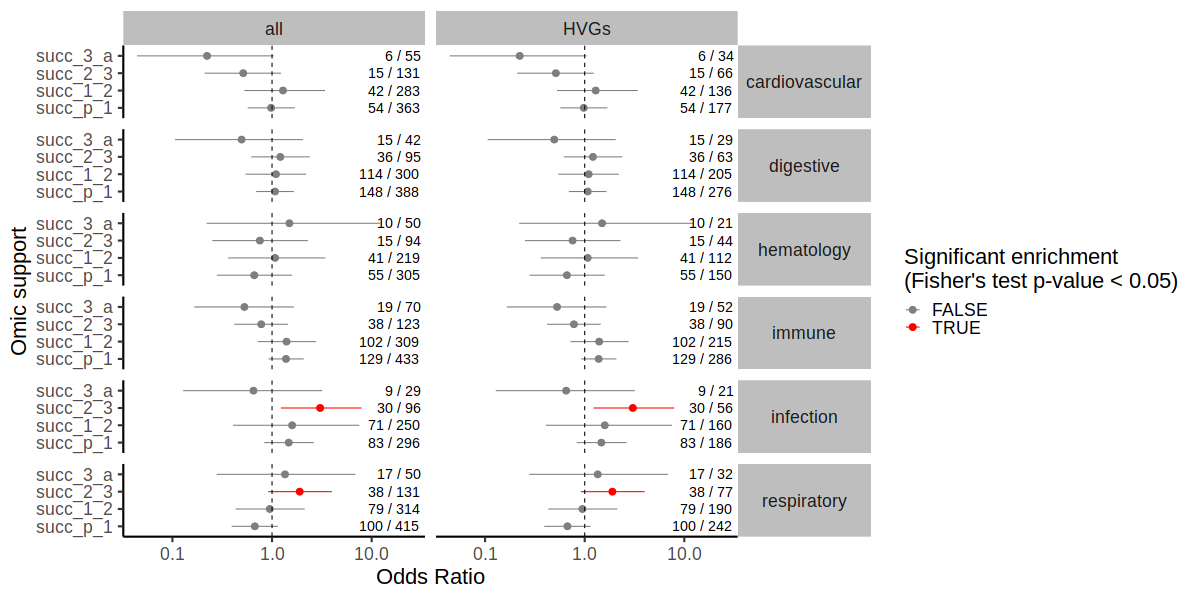

In [644]:
%%R -i results_filt_all_df -w 1200 -h 600 -i figdir
pl_df <- results_filt_all_df %>% filter(evidence == 'ct_marker_evidence')
plot_OR(pl_df, y_value='clinical_status',
        text_position='right', 
        evidence_levels=c('ct_marker_evidence'),
        clinical_status_levels = c('succ_p_1', 'succ_1_2', 'succ_2_3', 'succ_3_a'),
               base_font_size=22
       ) +
    facet_grid(area~universe, scales='free_x'
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
               
              ) +
    ylab("Omic support") +
    expand_limits(x=25) 


In [796]:
areas_all_df = pd.DataFrame()
for area in test_areas.keys():
    area_test_df = get_area_df(area, filter_congenital=False)
    area_test_df['area'] = area
    areas_all_df = pd.concat([areas_all_df, area_test_df])

areas_all_df['genetic_and_ct_marker'] = ((areas_all_df['has_genetic_evidence'] ==1) & (areas_all_df['ct_marker_evidence'] == 1)).astype(int)

In [797]:
results_combo_df = pd.DataFrame()
for ph in success_cols:
    for ev in ['ct_marker_evidence', 'has_genetic_evidence', 'genetic_and_ct_marker']:
        or_df = association_utils.get_OR(
            areas_all_df[areas_all_df.is_hvg_normal==1],  # universe HVGs
            evidence_col = ev, clinical_status_col=ph)
        or_df['universe'] = 'HVGs'
        results_combo_df = pd.concat([results_combo_df, or_df], axis=0)
        or_df = association_utils.get_OR(
            areas_all_df[(areas_all_df['combined_max_phase'] != 'None') & (areas_all_df.is_hvg_normal==1)],  # universe HVGs
            evidence_col = ev, clinical_status_col=ph)
        or_df['universe'] = 'preclinical_HVGs'
        results_combo_df = pd.concat([results_combo_df, or_df], axis=0)
        or_df = association_utils.get_OR(
            areas_all_df[(areas_all_df['combined_max_phase'] != 'None') ],  # universe HVGs
            evidence_col = ev, clinical_status_col=ph)
        or_df['universe'] = 'preclinical'
        results_combo_df = pd.concat([results_combo_df, or_df], axis=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


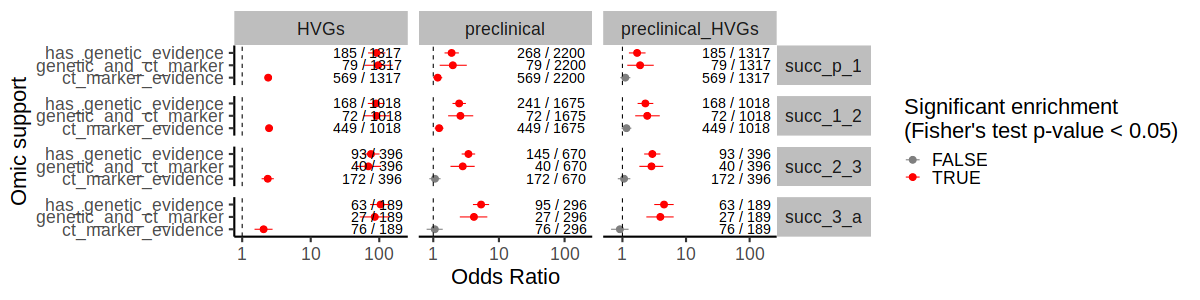

In [801]:
%%R -i results_combo_df -w 1200 -h 300 -i figdir
pl_df <- results_combo_df 
plot_OR(pl_df, y_value='evidence',
        text_position='right', 
        evidence_levels=c('ct_marker_evidence'),
        clinical_status_levels = c('succ_p_1', 'succ_1_2', 'succ_2_3', 'succ_3_a'),
               base_font_size=22
       ) +
    facet_grid(clinical_status~universe, scales='free_x'
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
               
              ) +
    ylab("Omic support") +
    expand_limits(x=200) 

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


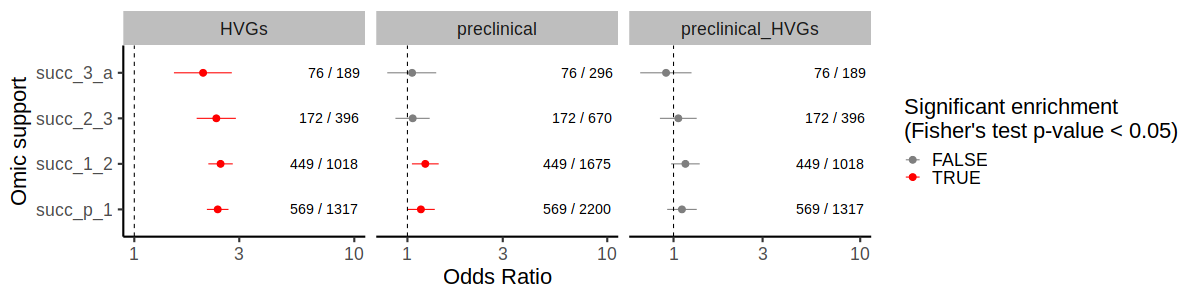

In [802]:
%%R -i results_combo_df -w 1200 -h 300 -i figdir
pl_df <- results_combo_df %>% filter(evidence == 'ct_marker_evidence' )
plot_OR(pl_df, y_value='clinical_status',
        text_position='right', 
        evidence_levels=c('ct_marker_evidence'),
        clinical_status_levels = c('succ_p_1', 'succ_1_2', 'succ_2_3', 'succ_3_a'),
               base_font_size=22
       ) +
    facet_grid(.~universe, scales='free_x'
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
               
              ) +
    ylab("Omic support") +
    expand_limits(x=10) 

In [671]:
count_ev_all = areas_all_df.groupby(['combined_max_phase', 'area'])[['ct_marker_evidence', 'has_genetic_evidence', 'is_hvg_normal']].sum().reset_index()
count_ev_all['total'] = areas_all_df.groupby(['combined_max_phase', 'area']).size().values

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


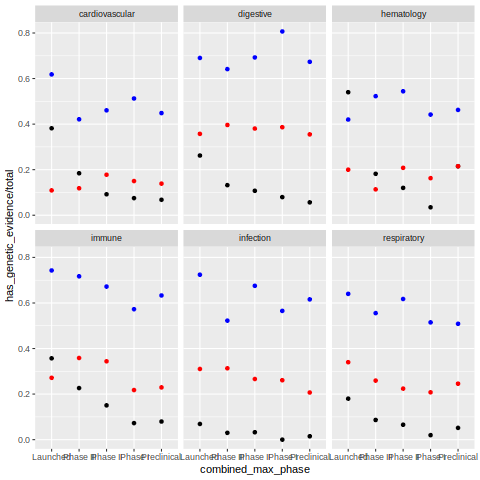

In [676]:
%%R -i count_ev_all 
count_ev_all %>%
mutate(combined_max_phase = factor(
    combined_max_phase, 
    levels = rev(c('Preclinical', 'Phase I', 'Phase II', 'Phase III','Launched')))) %>%
filter(combined_max_phase != 'None') %>%
ggplot(aes(combined_max_phase)) +
geom_point(aes(y= has_genetic_evidence/total)) +
geom_point(aes(y= ct_marker_evidence/total), color='red') +
geom_point(aes(y= is_hvg_normal/total), color='blue') +
facet_wrap(area~.)

In [647]:
results_combo_df[results_combo_df['universe'] == 'preclinical_HVGs']

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,universe
0,1.109390,0.924614,1.331712,1.364929e-01,1317.0,799.0,569.0,894.0,ct_marker_evidence,succ_p_1,preclinical_HVGs
0,1.701578,1.264355,2.309916,1.495245e-04,1317.0,799.0,185.0,255.0,has_genetic_evidence,succ_p_1,preclinical_HVGs
0,1.157863,0.970576,1.381443,5.254182e-02,1018.0,1098.0,449.0,894.0,ct_marker_evidence,succ_1_2,preclinical_HVGs
0,2.295901,1.732483,3.058948,8.617751e-10,1018.0,1098.0,168.0,255.0,has_genetic_evidence,succ_1_2,preclinical_HVGs
0,1.061357,0.845497,1.330884,3.176184e-01,396.0,1720.0,172.0,894.0,ct_marker_evidence,succ_2_3,preclinical_HVGs
0,2.949935,2.195874,3.949041,5.065909e-13,396.0,1720.0,93.0,255.0,has_genetic_evidence,succ_2_3,preclinical_HVGs
0,0.911869,0.663023,1.248735,7.484298e-01,189.0,1927.0,76.0,894.0,ct_marker_evidence,succ_3_a,preclinical_HVGs
0,4.513317,3.165022,6.396519,2.885193e-16,189.0,1927.0,63.0,255.0,has_genetic_evidence,succ_3_a,preclinical_HVGs


In [648]:
results_combo_df[results_combo_df['universe'] == 'HVGs']

,odds_ratio,ci_low,ci_high,pval,n_success,n_insuccess,n_supported_approved,n_supported,evidence,clinical_status,universe
0,2.393958,2.137579,2.680012,2.839382e-50,1317.0,39232.0,569.0,10029.0,ct_marker_evidence,succ_p_1,HVGs
0,91.375340,68.575805,122.890331,8.049346e-219,1317.0,39232.0,185.0,255.0,has_genetic_evidence,succ_p_1,HVGs
0,2.466996,2.170298,2.802975,1.659805e-42,1018.0,39531.0,449.0,10029.0,ct_marker_evidence,succ_1_2,HVGs
0,89.544861,68.073161,118.461154,9.282649e-207,1018.0,39531.0,168.0,255.0,has_genetic_evidence,succ_1_2,HVGs
0,2.359990,1.920745,2.895642,2.566819e-16,396.0,40153.0,172.0,10029.0,ct_marker_evidence,succ_2_3,HVGs
0,75.693115,56.595811,100.871599,6.767455e-122,396.0,40153.0,93.0,255.0,has_genetic_evidence,succ_2_3,HVGs
0,2.054687,1.514244,2.774997,1.915263e-06,189.0,40360.0,76.0,10029.0,ct_marker_evidence,succ_3_a,HVGs
0,104.456783,73.497335,147.533003,2.961000e-92,189.0,40360.0,63.0,255.0,has_genetic_evidence,succ_3_a,HVGs


## Match by disease (not area)

In [729]:
shared_diseases = np.intersect1d(
    nelson_targets_df['MONDO'].unique().tolist(), 
    targets_evidence_all.disease_ontology_id.unique().tolist())

(18,)

In [821]:
disease_nelson_targets_df = nelson_targets_df[nelson_targets_df['MONDO'].isin(shared_diseases)].copy()
disease_nelson_targets_df = disease_nelson_targets_df.rename({'MONDO':'disease_ontology_id'}, axis=1)
disease_nelson_targets_df = disease_nelson_targets_df[['gene_id', 'disease_ontology_id', 'combined_max_phase', 'target_status'] + success_cols].copy()
disease_nelson_targets_df = disease_nelson_targets_df.fillna(False)
disease_nelson_targets_df[success_cols] = disease_nelson_targets_df[success_cols].astype(int)

In [826]:
disease_evidence_all = pd.merge(targets_evidence_all[targets_evidence_all.disease_ontology_id.isin(shared_diseases)], disease_nelson_targets_df, how='left')
disease_evidence_all['combined_max_phase'] = disease_evidence_all['combined_max_phase']
disease_evidence_all[success_cols] = disease_evidence_all[success_cols].fillna(0)
disease_evidence_all['ct_marker_evidence'] = disease_evidence_all['ct_marker_evidence'].fillna(0)

In [827]:
disease_evidence_all['has_genetic_evidence'] = np.where(disease_evidence_all.target_status == 'genetically supported target', 1, 0)
disease_evidence_all['genetic_and_ct_evidence'] = ((disease_evidence_all['has_genetic_evidence'] ==1) & (disease_evidence_all['ct_marker_evidence'] == 1)).astype(int)

In [828]:
## Select universes of genes
hvgs_df = disease_evidence_all[disease_evidence_all.is_hvg_normal==1].copy()
prec_df = disease_evidence_all[(~disease_evidence_all['combined_max_phase'].isna())].copy()
prec_hvgs_df = disease_evidence_all[(~disease_evidence_all['combined_max_phase'].isna()) & (disease_evidence_all.is_hvg_normal==1)].copy()

In [829]:
results_disease_df = pd.DataFrame()
for ph in success_cols:
    for ev in ['ct_marker_evidence', 'has_genetic_evidence', 'genetic_and_ct_evidence']:
        or_df = association_utils.get_OR(
            hvgs_df,  # universe HVGs
            evidence_col = ev, clinical_status_col=ph)
        or_df['universe'] = 'HVGs'
        results_disease_df = pd.concat([results_disease_df, or_df], axis=0)
        or_df = association_utils.get_OR(
            prec_hvgs_df,  # universe preclinical HVGs
            evidence_col = ev, clinical_status_col=ph)
        or_df['universe'] = 'preclinical_HVGs'
        results_disease_df = pd.concat([results_disease_df, or_df], axis=0)
        or_df = association_utils.get_OR(
            prec_df,  # universe preclinical HVGs
            evidence_col = ev, clinical_status_col=ph)
        or_df['universe'] = 'preclinical'
        results_disease_df = pd.concat([results_disease_df, or_df], axis=0)

/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


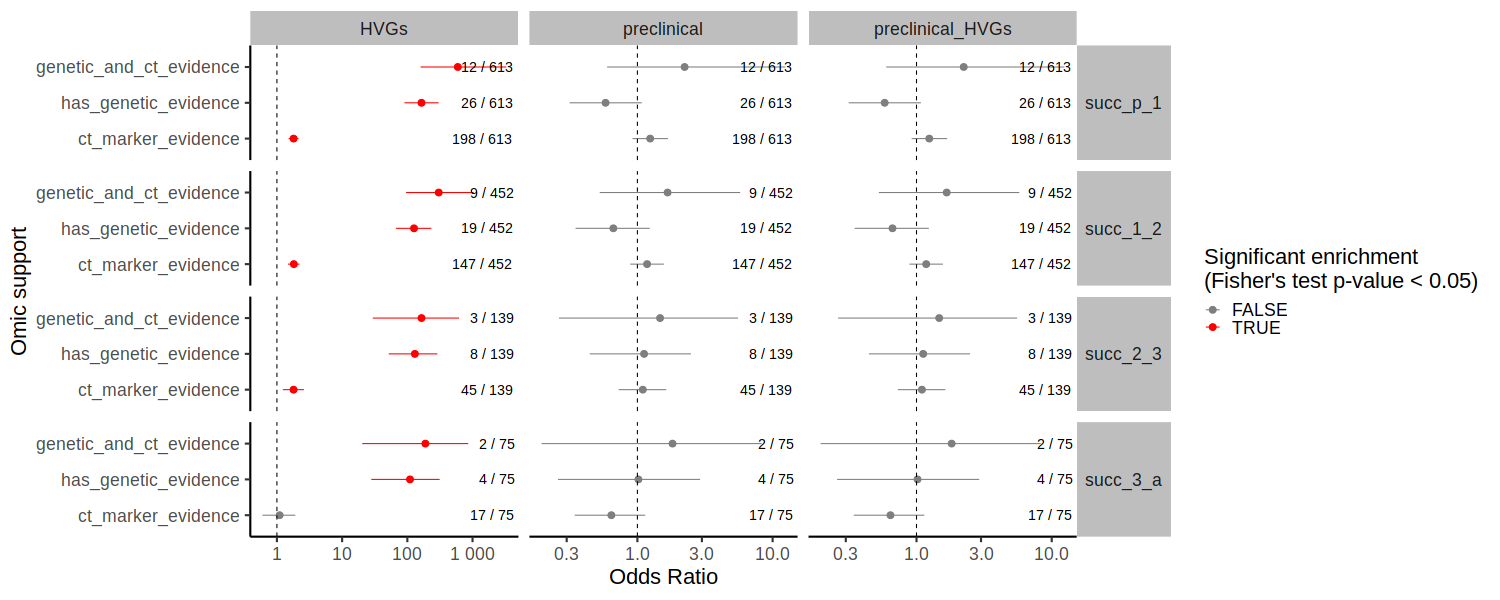

In [832]:
%%R -i results_disease_df -w 1500 -h 600 -i figdir
pl_df <- results_disease_df 
plot_OR(pl_df, y_value='evidence',
        text_position='right', 
        evidence_levels=c('ct_marker_evidence', 'has_genetic_evidence', 'genetic_and_ct_evidence'),
        clinical_status_levels = c('succ_p_1', 'succ_1_2', 'succ_2_3', 'succ_3_a'),
               base_font_size=22
       ) +
    facet_grid(clinical_status~universe, scales='free_x'
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
               
              ) +
    ylab("Omic support") +
    expand_limits(x=5) 

## Filter diseases in each area

In [595]:
nelson_targets_df[nelson_targets_df['cardiovascular'] == 1][['indication_mesh_term', 'areas']].drop_duplicates()

,indication_mesh_term,areas
1036,Aneurysm,cardiovascular
1042,Angina Pectoris,"cardiovascular, signs/symptoms"
1075,"Angina, Unstable","cardiovascular, signs/symptoms"
1088,Fabry Disease,"neurology, cardiovascular, congenital, metabolic"
1091,Angioedema,"cardiovascular, dermatology, immune"
...,...,...
24698,Glycogen Storage Disease Type IIb,"neurology, cardiovascular, congenital, metabolic"
24793,Acute Coronary Syndrome,cardiovascular
24822,"Angioedemas, Hereditary","cardiovascular, congenital, dermatology, immune"
25405,Microscopic Polyangiitis,"neurology, cardiovascular, immune"


In [596]:
nelson_targets_df[nelson_targets_df['cardiovascular'] == 1][['indication_mesh_term', 'areas']].drop_duplicates()[0:50]

,indication_mesh_term,areas
1036,Aneurysm,cardiovascular
1042,Angina Pectoris,"cardiovascular, signs/symptoms"
1075,"Angina, Unstable","cardiovascular, signs/symptoms"
1088,Fabry Disease,"neurology, cardiovascular, congenital, metabolic"
1091,Angioedema,"cardiovascular, dermatology, immune"
1209,Aortic Valve Stenosis,cardiovascular
1246,"Arrhythmias, Cardiac","cardiovascular, signs/symptoms"
1262,Arteriovenous Malformations,"cardiovascular, congenital"
1909,Ataxia Telangiectasia,"neurology, cardiovascular, congenital, metabol..."
1910,Atrial Fibrillation,"cardiovascular, signs/symptoms"


## Disease markers

In [782]:
def _parse_DE(
    disease_ontology_id, 
    signif_thresh = 0.01,
    DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'positive'},
    data_dir = '/nfs/team205/ed6/bin/sc_target_evidence/data/'
    ):
    '''Parse DE outputs for each disease and merge with OT clinical status and genetic evidence.
    
    Params
    ------
    disease_ontology_id
        Disease MONDO ID
    OT_targets_df
        Dataframe of OpenTargets target-disease pairs
    signif_thresh
        Threshold for DE adjusted p-value
    DE2evidence_celltype_params
        parameters passed to `DE2evidence_celltype_params`
    DE2evidence_disease_params
        parameters passed to `DE2evidence_disease_params`
    data_dir 
        path to directory storing DE results
        
    Returns
    -------
    targets_disease_df
        DataFrame of target-disease pairs with clinical status and omics evidence.
    '''
    disease_res = pd.read_csv(f'{data_dir}/DE_diseasecelltype_{disease_ontology_id.replace(":","_")}.hvgs.csv')
    bulk_res = pd.read_csv(f'{data_dir}/DE_diseasebulk_{disease_ontology_id.replace(":","_")}.hvgs.csv')

    evidence_dict = sc_evidence_utils.DE2evidence_disease(
        disease_res, bulk_res,  signif_thresh=signif_thresh, **DE2evidence_disease_params)
    evidence_dict['is_hvg_disease'] = disease_res.gene_id.unique()
    
    # Make target-disease table for sc evidence
    targets_disease_df = pd.DataFrame()
    targets_disease_df['gene_id'] = np.unique(np.hstack([x for x in evidence_dict.values()])) # Get all targets with sc evidence
    targets_disease_df['disease_ontology_id'] = disease_ontology_id

    for ev,targets in evidence_dict.items():
        targets_disease_df[ev] = targets_disease_df.gene_id.isin(targets).astype(int)
    return(targets_disease_df)

In [783]:
## Save evidence results for each disease
targets_evidence_disease_all = pd.DataFrame()
for disease_ontology_id in all_disease_ids:
    try:
        targets_disease_df = _parse_DE(
            disease_ontology_id, 
            signif_thresh = 0.01,
            DE2evidence_disease_params = {"lfc_thresh":0.5, 'lfc_group':'positive'}
        )
    except FileNotFoundError:
        print(f'missing {disease_ontology_id}')
        continue
    targets_disease_df['disease'] = disease_name_mapper[disease_ontology_id.replace('_', ":")]
    targets_disease_df['disease_relevant_tissue'] = disease_tissue_mapper[disease_ontology_id.replace('_', ":")]
    targets_evidence_disease_all = pd.concat([targets_evidence_disease_all, targets_disease_df], axis=0)

missing MONDO_0005575
missing MONDO_0024661
missing MONDO_0006156
missing MONDO_0006249
missing MONDO_0012883
missing MONDO_0018874
missing MONDO_0001056
missing MONDO_0024885
missing MONDO_0024660


In [784]:
targets_evidence_disease_all

,gene_id,disease_ontology_id,bulk_disease_evidence,disease_evidence,disease_ct_evidence,is_hvg_disease,disease,disease_relevant_tissue
0,ENSG00000000003,MONDO_0005097,0,1,1,1,squamous cell lung carcinoma,lung
1,ENSG00000000419,MONDO_0005097,0,0,0,1,squamous cell lung carcinoma,lung
2,ENSG00000000460,MONDO_0005097,0,0,0,1,squamous cell lung carcinoma,lung
3,ENSG00000000938,MONDO_0005097,0,0,0,1,squamous cell lung carcinoma,lung
4,ENSG00000000971,MONDO_0005097,0,0,0,1,squamous cell lung carcinoma,lung
...,...,...,...,...,...,...,...,...
12737,ENSG00000288558,MONDO_0015517,0,0,0,1,common variable immunodeficiency,blood
12738,ENSG00000288649,MONDO_0015517,0,0,0,1,common variable immunodeficiency,blood
12739,ENSG00000288675,MONDO_0015517,0,0,0,1,common variable immunodeficiency,blood
12740,ENSG00000288701,MONDO_0015517,0,0,0,1,common variable immunodeficiency,blood


In [833]:
disease_evidence_all = pd.merge(targets_evidence_disease_all[targets_evidence_disease_all.disease_ontology_id.isin(shared_diseases)], disease_nelson_targets_df, how='outer')
disease_evidence_all[success_cols] = disease_evidence_all[success_cols].fillna(0)
disease_evidence_all[['disease_evidence', 'bulk_disease_evidence', 'is_hvg_disease']] = disease_evidence_all[['disease_evidence', 'bulk_disease_evidence', 'is_hvg_disease']].fillna(0)

In [834]:
disease_evidence_all['has_genetic_evidence'] = np.where(disease_evidence_all.target_status == 'genetically supported target', 1, 0)
disease_evidence_all['genetic_and_disease_evidence'] = ((disease_evidence_all['has_genetic_evidence'] ==1) & (disease_evidence_all['disease_evidence'] == 1)).astype(int)

In [835]:
## Select universes of genes
hvgs_df = disease_evidence_all[disease_evidence_all.is_hvg_disease==1].copy()
prec_df = disease_evidence_all[(~disease_evidence_all['combined_max_phase'].isna())].copy()
prec_hvgs_df = disease_evidence_all[(~disease_evidence_all['combined_max_phase'].isna()) & (disease_evidence_all.is_hvg_disease==1)].copy()

In [836]:
results_disease_df = pd.DataFrame()
for ph in success_cols:
    for ev in ['disease_evidence', 'genetic_and_disease_evidence', 'has_genetic_evidence']:
        or_df = association_utils.get_OR(
            hvgs_df,  # universe HVGs
            evidence_col = ev, clinical_status_col=ph)
        or_df['universe'] = 'HVGs'
        results_disease_df = pd.concat([results_disease_df, or_df], axis=0)
        or_df = association_utils.get_OR(
            prec_hvgs_df,  # universe preclinical HVGs
            evidence_col = ev, clinical_status_col=ph)
        or_df['universe'] = 'preclinical_HVGs'
        results_disease_df = pd.concat([results_disease_df, or_df], axis=0)
        or_df = association_utils.get_OR(
            prec_df,  # universe preclinical HVGs
            evidence_col = ev, clinical_status_col=ph)
        or_df['universe'] = 'preclinical'
        results_disease_df = pd.concat([results_disease_df, or_df], axis=0)

In [844]:
for t in targets_evidence_all.disease_relevant_tissue.unique():
    print(t)

lung
stomach
nose
small intestine
kidney
heart
colon
lymph node
blood
bone marrow
prostate gland
esophagus
pancreas
breast
female reproductive tract


/home/jovyan/my-conda-envs/patho-signatures-2/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


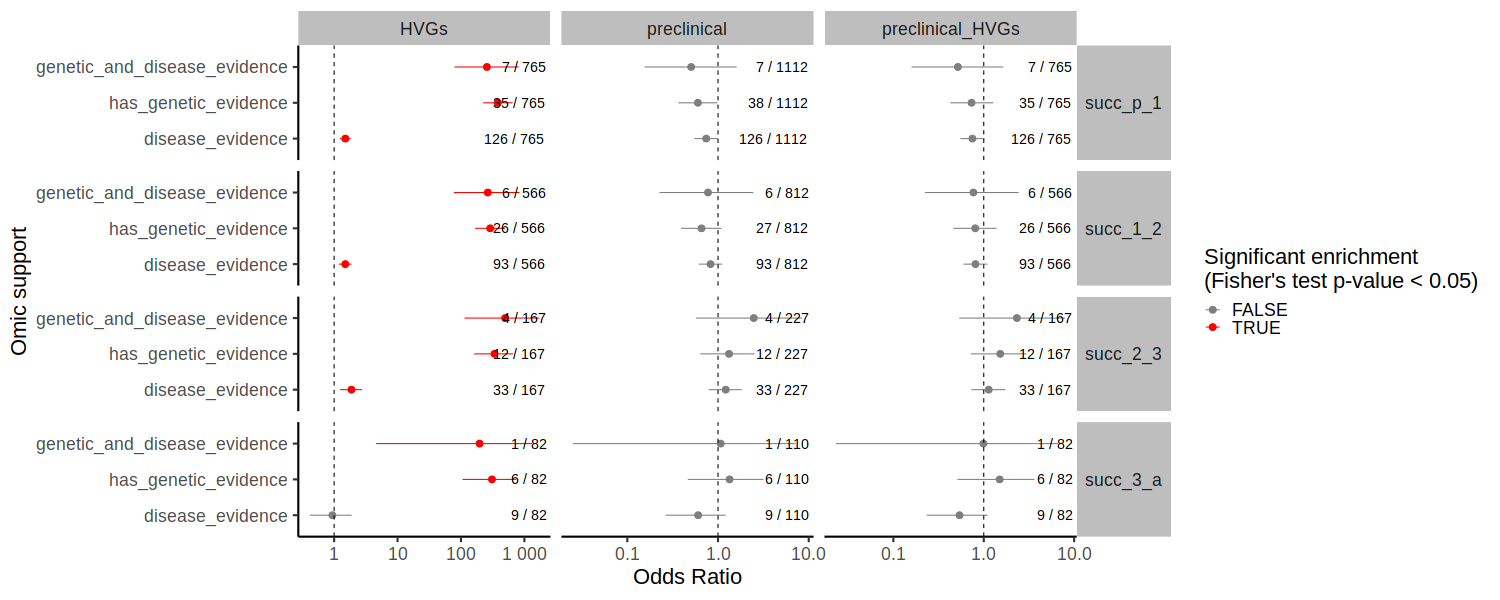

In [839]:
%%R -i results_disease_df -w 1500 -h 600 -i figdir
pl_df <- results_disease_df
plot_OR(pl_df, y_value='evidence',
        text_position='right', 
        evidence_levels=c('disease_evidence', 'has_genetic_evidence', 'genetic_and_disease_evidence'),
        clinical_status_levels = c('succ_p_1', 'succ_1_2', 'succ_2_3', 'succ_3_a'),
               base_font_size=22
       ) +
    facet_grid(clinical_status~universe, scales='free_x'
#                labeller = labeller(
#                    universe=as_labeller(uni_labeller)
               
              ) +
    ylab("Omic support") +
    expand_limits(x=5) 

In [793]:
disease_evidence_all.disease.unique()

array(['pneumonia', 'chronic kidney disease', 'myocardial infarction',
       'interstitial lung disease', 'follicular lymphoma',
       'benign prostatic hyperplasia', 'Barrett esophagus',
       'cystic fibrosis', 'small cell lung carcinoma', 'gastritis',
       'type 1 diabetes mellitus', 'acute kidney failure',
       'non-small cell lung carcinoma', 'cardiomyopathy', 'influenza',
       'chronic obstructive pulmonary disease',
       'systemic lupus erythematosus', nan], dtype=object)